In [2]:
import numpy as np 
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
device= "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
device

'cuda'

In [5]:
import audio 
spectrogram = audio.log_mel_spectrogram(r"F:\works\A-important\A-neurals\New folder\dev-clean\LibriSpeech\dev-clean\84\121123\84-121123-0001.flac") 

RuntimeError: Failed to load audio: ffmpeg version 2024-08-07-git-94165d1b79-full_build-www.gyan.dev Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 13.2.0 (Rev5, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-libsnappy --enable-zlib --enable-librist --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-libbluray --enable-libcaca --enable-sdl2 --enable-libaribb24 --enable-libaribcaption --enable-libdav1d --enable-libdavs2 --enable-libopenjpeg --enable-libquirc --enable-libuavs3d --enable-libxevd --enable-libzvbi --enable-libqrencode --enable-librav1e --enable-libsvtav1 --enable-libvvenc --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs2 --enable-libxeve --enable-libxvid --enable-libaom --enable-libjxl --enable-libvpx --enable-mediafoundation --enable-libass --enable-frei0r --enable-libfreetype --enable-libfribidi --enable-libharfbuzz --enable-liblensfun --enable-libvidstab --enable-libvmaf --enable-libzimg --enable-amf --enable-cuda-llvm --enable-cuvid --enable-dxva2 --enable-d3d11va --enable-d3d12va --enable-ffnvcodec --enable-libvpl --enable-nvdec --enable-nvenc --enable-vaapi --enable-libshaderc --enable-vulkan --enable-libplacebo --enable-opencl --enable-libcdio --enable-libgme --enable-libmodplug --enable-libopenmpt --enable-libopencore-amrwb --enable-libmp3lame --enable-libshine --enable-libtheora --enable-libtwolame --enable-libvo-amrwbenc --enable-libcodec2 --enable-libilbc --enable-libgsm --enable-libopencore-amrnb --enable-libopus --enable-libspeex --enable-libvorbis --enable-ladspa --enable-libbs2b --enable-libflite --enable-libmysofa --enable-librubberband --enable-libsoxr --enable-chromaprint
  libavutil      59. 32.100 / 59. 32.100
  libavcodec     61. 11.100 / 61. 11.100
  libavformat    61.  5.101 / 61.  5.101
  libavdevice    61.  2.100 / 61.  2.100
  libavfilter    10.  2.102 / 10.  2.102
  libswscale      8.  2.100 /  8.  2.100
  libswresample   5.  2.100 /  5.  2.100
  libpostproc    58.  2.100 / 58.  2.100
[in#0 @ 000002383ef896c0] Error opening input: No such file or directory
Error opening input file F:\works\A-important\A-neurals\New folder\dev-clean\LibriSpeech\dev-clean\84\121123\84-121123-0001.flac.
Error opening input files: No such file or directory


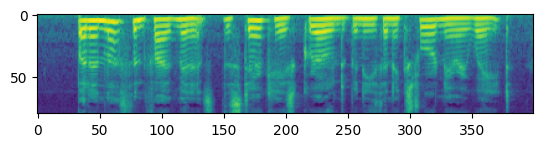

In [ ]:
plt.imshow(spectrogram);

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from dataclasses import dataclass


@dataclass
class Configuration:
    n_encoder_layers: int = 2
    n_decoder_layers: int = 4
    d_model: int = 512
    n_heads: int = 8
    d_ff: int = 2048
    max_seq_length: int = 1500
    vocab_size: int = 51876
    n_conv_channels: list = (80, 256, 512, 1024)
    dropout: float = 0.1


class PositionalEncoding(nn.Module):
    def __init__(self, max_len: int, d_model: int):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.pe[:x.size(0)]


class CustomAttention(nn.Module):
    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        self.query = nn.Linear(d_model, d_model, bias=False)
        self.key = nn.Linear(d_model, d_model, bias=False)
        self.value = nn.Linear(d_model, d_model, bias=False)
        self.out_proj = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)

    def scaled_dot_product_attention(self, q, k, v, mask=None):
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(self.head_dim)
        if mask is not None:
            attn_scores += mask
        attn_weights = F.softmax(attn_scores, dim=-1)
        return torch.matmul(attn_weights, v)

    def forward(self, q, k, v, mask=None):
        attn_output = self.scaled_dot_product_attention(q, k, v, mask)
        return self.out_proj(attn_output)


class EncoderLayer(nn.Module):
    def __init__(self, config: Configuration):
        super().__init__()
        self.attn = CustomAttention(config.d_model, config.n_heads, config.dropout)
        self.attn_layer_norm = nn.LayerNorm(config.d_model, eps=1e-4)
        self.activation = nn.SiLU()
        self.fc1 = nn.Linear(config.d_model, config.d_ff)
        self.fc2 = nn.Linear(config.d_ff, config.d_model)
        self.ffn_layer_norm = nn.LayerNorm(config.d_model, eps=1e-4)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        attn_output = self.attn(x, x, x)  # Self-attention
        x = self.attn_layer_norm(x + self.dropout(attn_output))

        # Feed-forward network
        ffn_output = self.fc2(self.dropout(self.activation(self.fc1(x))))
        x = self.ffn_layer_norm(x + ffn_output)
        return x


class DecoderLayer(nn.Module):
    def __init__(self, config: Configuration):
        super().__init__()
        self.self_attn = CustomAttention(config.d_model, config.n_heads, config.dropout)
        self.cross_attn = CustomAttention(config.d_model, config.n_heads, config.dropout)
        self.ffn = nn.Sequential(
            nn.Linear(config.d_model, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_model),
        )
        self.norm1 = nn.LayerNorm(config.d_model)
        self.norm2 = nn.LayerNorm(config.d_model)
        self.norm3 = nn.LayerNorm(config.d_model)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor, tgt_mask: torch.Tensor = None) -> torch.Tensor:
        # Self-attention
        self_attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(self_attn_output))

        # Cross-attention
        cross_attn_output = self.cross_attn(x, encoder_output, encoder_output)
        x = self.norm2(x + self.dropout(cross_attn_output))

        # Feed-forward network
        x = self.norm3(x + self.dropout(self.ffn(x)))
        return x


class SONATA_Encoder(nn.Module):
    def __init__(self, config: Configuration):
        super().__init__()
        self.conv1 = nn.Conv1d(config.n_conv_channels[0], config.n_conv_channels[1], 3, 1, 1)
        self.conv2 = nn.Conv1d(config.n_conv_channels[1], config.n_conv_channels[2], 3, 1, 1)
        self.conv3 = nn.Conv1d(config.n_conv_channels[2], config.n_conv_channels[3], 3, 2, 1)
        self.projection = nn.Linear(config.n_conv_channels[3], config.d_model)
        self.pos_embed = PositionalEncoding(config.max_seq_length, config.d_model)
        self.layers = nn.ModuleList([EncoderLayer(config) for _ in range(config.n_encoder_layers)])
        self.layer_norm = nn.LayerNorm(config.d_model, eps=1e-4)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.transpose(1, 2)
        x = self.projection(x)
        x = self.pos_embed(x)
        for layer in self.layers:
            x = layer(x)
        return self.layer_norm(x)


class SONATA_Decoder(nn.Module):
    def __init__(self, config: Configuration):
        super().__init__()
        self.embed_tokens = nn.Embedding(config.vocab_size, config.d_model)
        self.pos_embed = PositionalEncoding(config.max_seq_length, config.d_model)
        self.layers = nn.ModuleList([DecoderLayer(config) for _ in range(config.n_decoder_layers)])
        self.layer_norm = nn.LayerNorm(config.d_model, eps=1e-4)

    def forward(self, encoder_output: torch.Tensor, seperation: int, tgt_mask: torch.Tensor = None) -> torch.Tensor:
        # Directly use the encoder output as the input to the decoder
        if seperation:
            x = self.embed_tokens(encoder_output)
            x = self.pos_embed(x)
            for layer in self.layers:
                x = layer(x, encoder_output, tgt_mask)
            return self.layer_norm(x)
        else:
            x = self.pos_embed(encoder_output)
            for layer in self.layers:
                x = layer(x, encoder_output, tgt_mask)
            return self.layer_norm(x)
            


class SONATA(nn.Module):
    def __init__(self, config: Configuration):
        super().__init__()
        self.Encoder = SONATA_Encoder(config)
        self.Decoder = SONATA_Decoder(config)
        self.proj_out = nn.Linear(config.d_model, config.vocab_size)

    def forward(self, src: torch.Tensor, seperation: int, tgt_mask: torch.Tensor = None) -> torch.Tensor:
        encoder_output = self.Encoder(src)
        decoder_output = self.Decoder(encoder_output, seperation, tgt_mask)
        return self.proj_out(decoder_output)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Instantiate the model
config = Configuration()
model = SONATA(config)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

print(f"The model has {count_parameters(model):,} trainable parameters")

# Sample input
src = torch.randn(1, 80, 400).to(device)  # Simulated spectrogram: (batch_size, features, time_steps)
output = model(src=src, seperation = 0)
print(f"Batch Size: {1}, Output Shape: {output.shape}")


The model has 78,829,476 trainable parameters
Batch Size: 1, Output Shape: torch.Size([1, 200, 51876])


In [ ]:
spectrogram.reshape(-1, 80, 400).shape

torch.Size([1, 80, 400])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from dataclasses import dataclass


@dataclass
class Configuration:
    n_encoder_layers: int = 2
    n_decoder_layers: int = 4
    d_model: int = 512
    n_heads: int = 8
    d_ff: int = 2048
    max_seq_length: int = 1500
    vocab_size: int = 51876
    n_conv_channels: list = (80, 256, 512, 1024)
    dropout: float = 0.1


class PositionalEncoding(nn.Module):
    def __init__(self, max_len: int, d_model: int):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.pe[:x.size(0)]


class CustomAttention(nn.Module):
    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        self.query = nn.Linear(d_model, d_model, bias=False)
        self.key = nn.Linear(d_model, d_model, bias=False)
        self.value = nn.Linear(d_model, d_model, bias=False)
        self.out_proj = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)

    def scaled_dot_product_attention(self, q, k, v, mask=None):
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(self.head_dim)
        if mask is not None:
            attn_scores += mask
        attn_weights = F.softmax(attn_scores, dim=-1)
        return torch.matmul(attn_weights, v)

    def forward(self, q, k, v, mask=None):
        attn_output = self.scaled_dot_product_attention(q, k, v, mask)
        return self.out_proj(attn_output)


class EncoderLayer(nn.Module):
    def __init__(self, config: Configuration):
        super().__init__()
        self.attn = CustomAttention(config.d_model, config.n_heads, config.dropout)
        self.attn_layer_norm = nn.LayerNorm(config.d_model, eps=1e-4)
        self.activation = nn.SiLU()
        self.fc1 = nn.Linear(config.d_model, config.d_ff)
        self.fc2 = nn.Linear(config.d_ff, config.d_model)
        self.ffn_layer_norm = nn.LayerNorm(config.d_model, eps=1e-4)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        attn_output = self.attn(x, x, x)  # Self-attention
        x = self.attn_layer_norm(x + self.dropout(attn_output))

        # Feed-forward network
        ffn_output = self.fc2(self.dropout(self.activation(self.fc1(x))))
        x = self.ffn_layer_norm(x + ffn_output)
        return x


class DecoderLayer(nn.Module):
    def __init__(self, config: Configuration):
        super().__init__()
        self.self_attn = CustomAttention(config.d_model, config.n_heads, config.dropout)
        self.cross_attn = CustomAttention(config.d_model, config.n_heads, config.dropout)
        self.ffn = nn.Sequential(
            nn.Linear(config.d_model, config.d_ff),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.d_ff, config.d_model),
        )
        self.norm1 = nn.LayerNorm(config.d_model)
        self.norm2 = nn.LayerNorm(config.d_model)
        self.norm3 = nn.LayerNorm(config.d_model)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor, tgt_mask: torch.Tensor = None) -> torch.Tensor:
        # Self-attention
        self_attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(self_attn_output))

        # Cross-attention
        cross_attn_output = self.cross_attn(x, encoder_output, encoder_output)
        x = self.norm2(x + self.dropout(cross_attn_output))

        # Feed-forward network
        x = self.norm3(x + self.dropout(self.ffn(x)))
        return x


class SONATA_Encoder(nn.Module):
    def __init__(self, config: Configuration):
        super().__init__()
        self.conv1 = nn.Conv1d(config.n_conv_channels[0], config.n_conv_channels[1], 3, 1, 1)
        self.conv2 = nn.Conv1d(config.n_conv_channels[1], config.n_conv_channels[2], 3, 1, 1)
        self.conv3 = nn.Conv1d(config.n_conv_channels[2], config.n_conv_channels[3], 3, 2, 1)
        self.projection = nn.Linear(config.n_conv_channels[3], config.d_model)
        self.pos_embed = PositionalEncoding(config.max_seq_length, config.d_model)
        self.layers = nn.ModuleList([EncoderLayer(config) for _ in range(config.n_encoder_layers)])
        self.layer_norm = nn.LayerNorm(config.d_model, eps=1e-4)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.transpose(1, 2)
        x = self.projection(x)
        x = self.pos_embed(x)
        for layer in self.layers:
            x = layer(x)
        return self.layer_norm(x)


class SONATA_Decoder(nn.Module):
    def __init__(self, config: Configuration):
        super().__init__()
        self.embed_tokens = nn.Embedding(config.vocab_size, config.d_model)
        self.pos_embed = PositionalEncoding(config.max_seq_length, config.d_model)
        self.layers = nn.ModuleList([DecoderLayer(config) for _ in range(config.n_decoder_layers)])
        self.layer_norm = nn.LayerNorm(config.d_model, eps=1e-4)

    def forward(self, encoder_output: torch.Tensor, seperation: int, tgt_mask: torch.Tensor = None) -> torch.Tensor:
        # Directly use the encoder output as the input to the decoder
        if seperation:
            x = self.embed_tokens(encoder_output)
            x = self.pos_embed(x)
            for layer in self.layers:
                x = layer(x, encoder_output, tgt_mask)
            return self.layer_norm(x)
        else:
            x = self.pos_embed(encoder_output)
            for layer in self.layers:
                x = layer(x, encoder_output, tgt_mask)
            return self.layer_norm(x)
            


class SONATA(nn.Module):
    def __init__(self, config: Configuration):
        super().__init__()
        self.Encoder = SONATA_Encoder(config)
        self.Decoder = SONATA_Decoder(config)
        self.proj_out = nn.Linear(config.d_model, config.vocab_size)

    def forward(self, src: torch.Tensor, seperation: int, tgt_mask: torch.Tensor = None) -> torch.Tensor:
        encoder_output = self.Encoder(src)
        decoder_output = self.Decoder(encoder_output, seperation, tgt_mask)
        return self.proj_out(decoder_output)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Instantiate the model
config = Configuration()
model = SONATA(config)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

print(f"The model has {count_parameters(model):,} trainable parameters")

# Sample input
src = torch.randn(1600, 80, 400).to(device)  # Simulated spectrogram: (batch_size, features, time_steps)
output = model(src=src, seperation = 0)
print(f"Batch Size: {1}, Output Shape: {output.shape}")


The model has 78,829,476 trainable parameters


RuntimeError: The size of tensor a (1600) must match the size of tensor b (1500) at non-singleton dimension 0

In [ ]:
spectrogram= spectrogram.reshape(1, 80, 400).to(device="cuda")
model(spectrogram, 0).shape

torch.Size([1, 200, 51876])

In [ ]:
import os 

def load_tokens(filename):
    npt = np.load(filename)
    npt = npt.astype(np.int32)
    ptt = torch.tensor(npt, dtype=torch.long)
    return ptt

class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T
        data_root = r"F:\works\A-important\A-neurals\SONATA\data"  
        shards = os.listdir(data_root)
        shards = [s for s in shards if split in s]
        shards = sorted(shards)
        shards = [os.path.join(data_root, s) for s in shards]
        self.shards = shards
        
        print(f"found {len(shards)} shards for split {split}")
        self.reset()

    def reset(self):
        self.current_shard = 0
        self.tokens = load_tokens(self.shards[self.current_shard])
        self.current_position = 0

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position+B*T+1]
        x = (buf[:-1]).view(B, T)
        y = (buf[1:]).view(B, T)
        self.current_position += B * T
        if self.current_position + (B * T + 1) > len(self.tokens):
            self.current_shard = (self.current_shard + 1) % len(self.shards)
            self.tokens = load_tokens(self.shards[self.current_shard])
            self.current_position = 0
        return x.to(device), y.to(device)

In [11]:
import tiktoken 
enc = tiktoken.get_encoding("gpt2")

In [28]:
enc.decode([50256])

'<|endoftext|>'

In [23]:
enc.decode([0])

'!'